# Выбор локации для нефтяной скважины

**Задача:** Построит модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.  

**Дано:** пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.   

**План:**  

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Особенности**    
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.    
Бюджет на разработку скважин в регионе — **10 млрд рублей.**   
Цена за баррель **450 рублей дохода.**  
Доход с каждой единицы продукта составляет 450 тыс.рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.   


## Загрузка и подготовка данных

**Импорты**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

**Датасеты**

In [2]:
reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
reg_1.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
reg_2.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
reg_3.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
reg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
reg_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных не выявлено.

- id — идентификатор скважины
- f0, f1, f2 — три признака точек
- product — объём запасов в скважине 

In [9]:
reg_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [10]:
reg_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
reg_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Дубликаты**

In [12]:
print('Количество полных дубликатов по региону 1:', reg_1.duplicated().sum())
print('Количество полных дубликатов по региону 2:', reg_2.duplicated().sum())
print('Количество полных дубликатов по региону 3:', reg_3.duplicated().sum())

Количество полных дубликатов по региону 1: 0
Количество полных дубликатов по региону 2: 0
Количество полных дубликатов по региону 3: 0


**Распределение переменных**

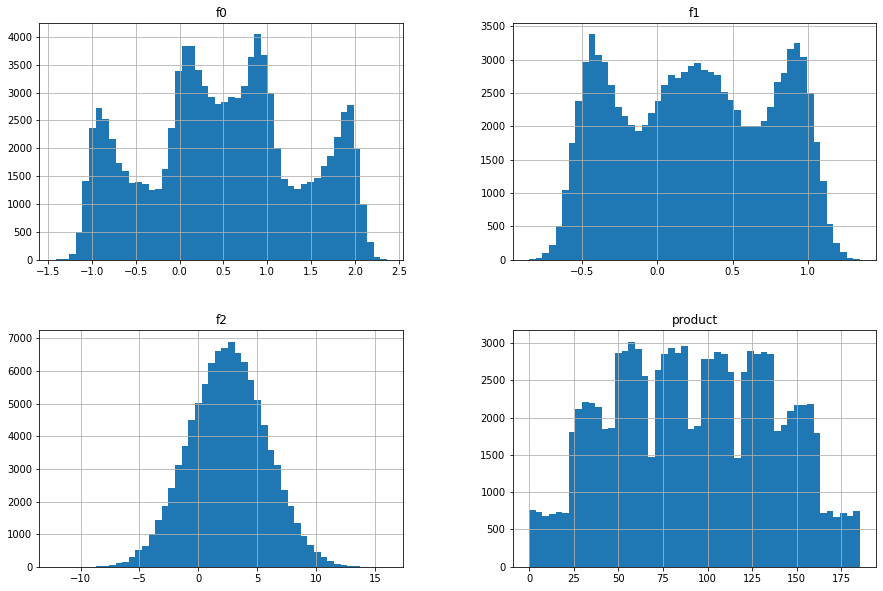

In [13]:
reg_1.hist(bins=50, figsize=(15,10))
plt.show()

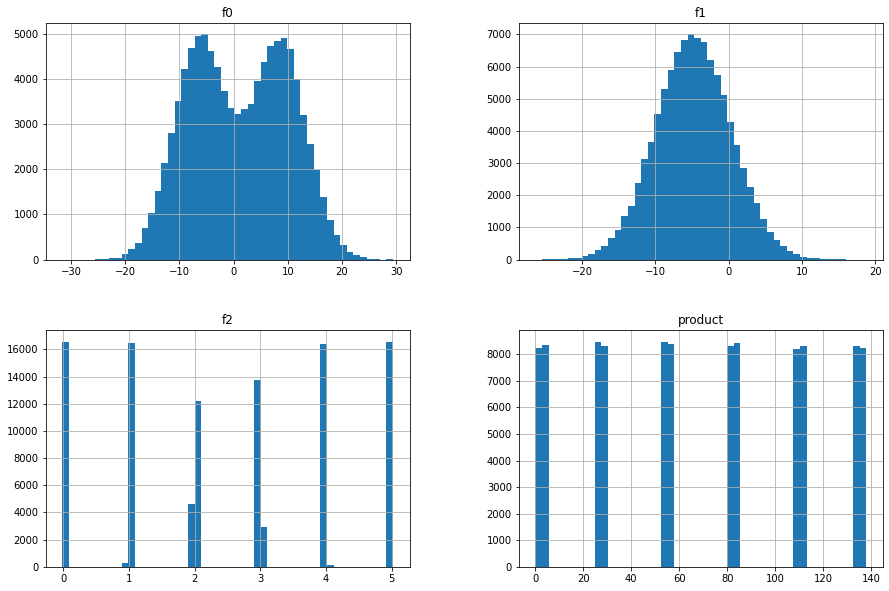

In [14]:
reg_2.hist(bins=50, figsize=(15,10))
plt.show()

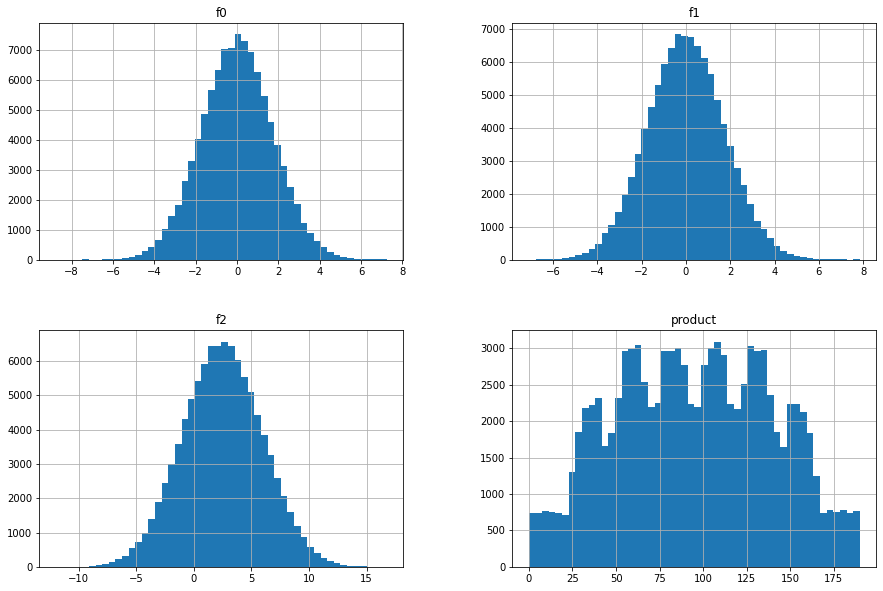

In [15]:
reg_3.hist(bins=50, figsize=(15,10))
plt.show()

In [16]:
reg_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [17]:
reg_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [18]:
reg_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Удаление столбца ID**

In [19]:
df_1 = reg_1.drop('id', axis=1)
df_2 = reg_2.drop('id', axis=1)
df_3 = reg_3.drop('id', axis=1)

**Вывод**  
Без понимания смысла признаков затруднительно проверить наличие шума и аномалий в типах признаков точек.  
Признак id малополезен для обучения модели, поэтому он удален из датасетов.  
По датасету №2 обнаружено алогичное распределение по фичам: f2 и product. Корректность данных по вопросом. Следует уточнить у коллег, почему данные по второму региону так разительно отличаются от первого и третьего регионов. 

## Обучение и проверка модели

Линейная регрессия

In [20]:
model = LinearRegression()

Параметры для подбора

In [21]:
par_grid = {
              'fit_intercept':[True, False], 
              'normalize':[True, False], 
              'copy_X':[True, False]
         }


Регион 1

In [22]:
# функция разделения выборки на фичи и таргеты
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]


In [23]:
features_1, target_1 = split_data(df_1,'product')
X_train_1, X_test_1, y_train_1, y_test_1 = ( 
                                     train_test_split(
                                     features_1, target_1, test_size=.25, 
                                      random_state=1589)
                                     )

In [24]:
grid_search = GridSearchCV(model, par_grid, cv=5)
grid_search.fit(X_train_1, y_train_1)
lr_1 = grid_search.best_estimator_

In [25]:
predicted_prod_1 = lr_1.predict(X_test_1)

In [26]:
def report(rep, y, region, pred):
    rep = pd.DataFrame(y)
    rep['predicted'] = pred
    rep['region'] = region
    return rep

In [27]:
reg_1_report = []
reg_1_report = report(reg_1_report, y_test_1, 1, predicted_prod_1)
reg_1_report.head()

,product,predicted,region
67799,159.898358,138.261314,1
89387,95.882141,113.621241,1
36175,112.308916,129.709500,1
34868,110.996795,62.774885,1
97580,87.723043,90.824260,1


In [28]:
def prms(report, true, pred):
    return print(f'Средние запасы в региону: {report.mean()}\n',
                f'MSE:{mean_squared_error(true, pred)}\n',
                f'MAE:{mean_absolute_error(true, pred)}\n',
                f'RMSE:{np.sqrt(mean_squared_error(true, pred))}')
prms(reg_1_report['predicted'], y_test_1, predicted_prod_1)

Средние запасы в региону: 92.20564421296301
 MSE:1429.8372137283825
 MAE:31.11398563068198
 RMSE:37.81318835708492


**Вывод:**

Модель предсказывает 92.2 тыс. баррелей нефти по региону  
Среднеквадратичная ошибка прогноза - 1429.83  
Квадратный корень из среднеквадратичной ошибки - 37.81  
Средняя абсолютная ошибка для первого региона - 31.12

Регион 2

In [29]:
features_2, target_2 = split_data(df_2,'product')

In [30]:
X_train_2, X_test_2, y_train_2, y_test_2 = ( 
                                     train_test_split(
                                     features_2, target_2, test_size=.25, 
                                      random_state=1589)
                                     )

In [31]:
grid_search = GridSearchCV(model, par_grid, cv=5)
grid_search.fit(X_train_2, y_train_2)
lr_2 = grid_search.best_estimator_
predicted_prod_2 = lr_2.predict(X_test_2)

In [32]:
reg_2_report = []
reg_2_report = report(reg_2_report, y_test_2, 2, predicted_prod_2)
reg_2_report.head()

,product,predicted,region
67799,137.945408,138.603276,2
89387,26.953261,28.534749,2
36175,84.038886,83.254194,2
34868,30.132364,28.810559,2
97580,26.953261,28.788898,2


In [33]:
prms(reg_2_report['predicted'], y_test_2, predicted_prod_2)

Средние запасы в региону: 68.4860978315421
 MSE:0.7972533325844734
 MAE:0.7194678555764945
 RMSE:0.8928904370551145


**Вывод:**

Модель предсказывает 68.48 тыс. баррелей нефти по региону  
Среднеквадратичная ошибка прогноза - 0.79 
Квадратный корень из среднеквадратичной ошибки - 0.71  
Средняя абсолютная ошибка для первого региона - 0.89

**Распределение данных и метрики значительно отличаются от первого и третьего региона, вероятно данные ошибочны или некорректны. Необходимо уточнить у заказчика**

Регион 3

In [34]:
features_3, target_3 = split_data(df_3,'product')

In [35]:
X_train_3, X_test_3, y_train_3, y_test_3 = ( 
                                     train_test_split(
                                     features_3, target_3, test_size=.25, 
                                      random_state=1589)
                                     )

In [36]:
grid_search = GridSearchCV(model, par_grid, cv=5)
grid_search.fit(X_train_3, y_train_3)
lr_3 = grid_search.best_estimator_
predicted_prod_3 = lr_3.predict(X_test_3)

In [37]:
reg_3_report = []
reg_3_report = report(reg_3_report, y_test_3, 3, predicted_prod_3)
reg_3_report.head()

,product,predicted,region
67799,51.682963,102.640412,3
89387,72.973424,71.153994,3
36175,164.029923,67.188506,3
34868,120.691336,107.248482,3
97580,37.604379,68.699091,3


In [38]:
prms(reg_3_report['predicted'], y_test_3, predicted_prod_3)

Средние запасы в региону: 95.06236588758902
 MSE:1606.6645410382546
 MAE:32.837657124296875
 RMSE:40.0832201929717


**Вывод:**

Модель предсказывает 95.06 тыс. баррелей нефти по региону  
Среднеквадратичная ошибка прогноза - 1 606.66  
Квадратный корень из среднеквадратичной ошибки - 32.83  
Средняя абсолютная ошибка для первого региона - 40.08

**Данные похожи на данные первого региона и значительно отличаются от второго. Вероятно данные по второму региону некорректны**

In [39]:
# функция сбора метрик по каждой модели
results = []
def big_data(report, true, pred, name):
    mean_prod = report.mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return results.append((name, mean_prod, mse, rmse, mae, r2))

In [40]:
big_data(reg_1_report['predicted'], y_test_1, predicted_prod_1, 'Region_1')
big_data(reg_2_report['predicted'], y_test_2, predicted_prod_2, 'Region_2')
big_data(reg_3_report['predicted'], y_test_3, predicted_prod_3, 'Region_3')

Объедининим итоги изучения моделей в один дф.

In [41]:
reg_info = pd.DataFrame(results, columns=['model', 'mean', 'mse', 'rmse', 'mae', 'r2'])
reg_info 

,model,mean,mse,rmse,mae,r2
0,Region_1,92.205644,1429.837214,37.813188,31.113986,0.270045
1,Region_2,68.486098,0.797253,0.892890,0.719468,0.999624
2,Region_3,95.062366,1606.664541,40.083220,32.837657,0.197502


**Вывод**
Модели линейной регрессии:
- RMSE 1 модели: 37.81
- RMSE 2 модели: 0.89
- RMSE 3 модели: 40.08

Средние запасы, предсказанные моделью:
- Среднее 1 модели: 92.2
- Среднее 2 модели: 68.4
- Среднее 3 модели: 95.06

## Подготовка к расчёту прибыли

In [42]:
# константные переменные для расчёта прибыли
BUDGET = 10*10**9
ALL_HOLLES = 200
BARELL_PRICE = 450*10**3
GOOD_PRICE = int(BUDGET / ALL_HOLLES)

Соберём данные в таблицу.

In [43]:
all_var = pd.DataFrame({'Бюджет, руб': [BUDGET], 'Количество скважин, ед.':[ALL_HOLLES],
                        'Стоимость бурения, руб': [GOOD_PRICE], 'Цена за 1000 баррелей, руб':[BARELL_PRICE]}
                       )

all_var

,"Бюджет, руб","Количество скважин, ед.","Стоимость бурения, руб","Цена за 1000 баррелей, руб"
0,10000000000,200,50000000,450000


Точка безубыточности. Мин.запас на 1 скважину.

In [44]:
OIL_BASE = GOOD_PRICE / BARELL_PRICE
OIL_BASE 

111.11111111111111

In [45]:
reg_info['difference'] = reg_info['mean'] - OIL_BASE 
reg_info

,model,mean,mse,rmse,mae,r2,difference
0,Region_1,92.205644,1429.837214,37.813188,31.113986,0.270045,-18.905467
1,Region_2,68.486098,0.797253,0.892890,0.719468,0.999624,-42.625013
2,Region_3,95.062366,1606.664541,40.083220,32.837657,0.197502,-16.048745


Выясним доли перспективных скважин по регионам.

In [46]:
reg_1_profit = reg_1_report.query('product >= 111.11').shape[0]/  reg_1_report.shape[0]
reg_1_profit

0.36812

In [47]:
reg_2_profit = reg_2_report.query('product >= 111.11').shape[0]/  reg_2_report.shape[0]
reg_2_profit

0.1626

In [48]:
reg_3_profit = reg_3_report.query('product >= 111.11').shape[0]/  reg_3_report.shape[0]
reg_3_profit

0.38308

In [49]:
reg_2['product'].sum()

6882500.000000002

In [50]:
reg_1['product'].sum()

9250000.000000002

In [51]:
reg_3['product'].sum()

9500000.000000004

Доля безубыточных скважин:
- Регион 1: 36%
- Регион 2: 16%
- Регион 3: 38%    

**Вывод** 
В начальных данных регион 2 проигрывает региону 1 и 2 по запасам нефти. При этом по прогнозам модели это самый успешный регион. Вероятно это связано с некорректными данными. Так как доля безубыточных скважин согласно расчётом во втором регионе в 2 раза меньше, чем в первом и третьем.

## Расчёт прибыли и рисков 

In [52]:
# функция отбора 200 лучших скважин по каждому региону и расчёту прибыли
def big_profit(report):
    top_200 = report.sort_values(by=['predicted'], ascending=False)[:200]
    true_sort_sum = report['product'][top_200.index].sum() 
    return (((true_sort_sum * BARELL_PRICE) - BUDGET)/ (10**9))
reg_1_income = big_profit(reg_1_report)
reg_2_income = big_profit(reg_2_report)
reg_3_income = big_profit(reg_3_report)

In [53]:
print(f'Прогноз дохода, регион 1', reg_1_income)
print(f'Прогноз дохода, регион 2', reg_2_income)
print(f'Прогноз дохода, регион 3', reg_3_income)

Прогноз дохода, регион 1 3.3875565525201665
Прогноз дохода, регион 2 2.4150866966815108
Прогноз дохода, регион 3 2.5031506159786625


In [54]:
reg_1_pure_prof = reg_1_income*10**9/BUDGET
reg_2_pure_prof = reg_2_income*10**9/BUDGET
reg_3_pure_prof = reg_3_income*10**9/BUDGET

In [55]:
print(f'Прогноз прибыли, регион 1', reg_1_pure_prof)
print(f'Прогноз прибыли, регион 2', reg_2_pure_prof)
print(f'Прогноз прибыли, регион 3', reg_3_pure_prof)

Прогноз прибыли, регион 1 0.3387556552520166
Прогноз прибыли, регион 2 0.2415086696681511
Прогноз прибыли, регион 3 0.25031506159786626


Прибыль с региона 1 относительно затрат: 33.8%  
Прибыль с региона 2 относительно затрат: - 26.0%  
Прибыль с региона 3 относительно затрат: 26.7%

In [56]:
# функция расчёта выручки и риска по полученным ранее репортам
def risks_profit(report):
    values = []
    state = np.random.RandomState(1589) 
    
    for i in range(1000):
        
        probs_subsample = report['predicted'].sample(n=500, replace=True, random_state=state)     
        probs_top = probs_subsample.sort_values(ascending=False)
        cur_top_200 = report['product'][probs_top.index][:200]
        profit = ((BARELL_PRICE * cur_top_200.sum()) - BUDGET)/ (10**9)
        values.append(profit)
        
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    confidence_interval = st.t.interval(0.95, len(values)-1, 
                                        mean, values.sem())
    

    risk = (values < 0).mean() * 100
        
    print(f'Средняя выручка: {mean}')
    print(f'2.5%-квантиль: {lower}')
    print(f'97.5%-квантиль: {upper}')
    print(f'95% доверительный интервал: {confidence_interval}')
    print(f'Риски: {risk}%')

In [57]:
risks_profit(reg_1_report)

Средняя выручка: 0.4456370317256681
2.5%-квантиль: -0.06200955515184459
97.5%-квантиль: 0.9447532693735963
95% доверительный интервал: (0.4299889107256871, 0.4612851527256491)
Риски: 4.2%


Вероятность получить более 0.43 млрд. составляет более 95%. Риск убыточности: 4.2%

In [58]:
risks_profit(reg_2_report)

Средняя выручка: 0.4275249894915243
2.5%-квантиль: 0.03882137598422027
97.5%-квантиль: 0.8188352736064665
95% доверительный интервал: (0.41480796844161333, 0.44024201054143525)
Риски: 1.3%


Вероятность получить более 0.41 млрд. составляет более 95%. Риск убыточности: 1.3% 

In [59]:
risks_profit(reg_3_report)

Средняя выручка: 0.3772701655525899
2.5%-квантиль: -0.16544558104210608
97.5%-квантиль: 0.8978051334551966
95% доверительный интервал: (0.36071457906856613, 0.3938257520366137)
Риски: 7.199999999999999%


Вероятность получить более 0.36 млрд. составляет более 95%. Риск убыточности: 7.2% 

## Вывод

В рамках задачи были изучены данные по нефтерождениями в трёх регионах: в каждом 10 000 шт.  
Была построена модель машинного обучения - Линейная регрессия, с помощью которой определен самый прибыльный регион.

Лучший результаты по прибыли показал РЕГИОН 1 - 0.43 млрд рублей прогнозируемых.

Проверка средней выручки техникой Bootsrap - наилучший результат и наименьшие риски показали РЕГИОН 1 и РЕГИОН 3. 

По РЕГИОН 2 выявлены значительные разночтения с другими регионами. Вероятно данные некорректные и не могут быть применены для анализа и прогнозов. Данную гипотезу требуется дополнительно проверить.

**Итог** по результатам проведенного анализа предлагается рассмотреть РЕГИОН 1 для инвестиций в месторождения.